In [ ]:
# encoding=utf8

# Principal Component Analysis (PCA) - Singular Value Decomposition (SVD)

In [1]:
# Python 3.5 environment
# Load libraries

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D, proj3d
from matplotlib.patches import FancyArrowPatch
from IPython import display


### Principal Component Analysis (PCA) - Fitting a plane

#### 1. Mathematical Derivation of PCA

Without going much in details the general procedure is as follows:

1. Input Data: Here I generated some simulated data, but you can usually apply PCA to any numerical/continuous data matrix. If you have mixed data, it becomes more complicated and you should look into "[Multiple Factor Analysis](https://en.wikipedia.org/wiki/Multiple_factor_analysis)".
2. Subtract respective mean of each column (PCA will be based on variance-covariance matrix) or subtract mean and divide by standard deviation respectively (PCA will be based on correlation matrix in this case)
3. Derive variance-covariance matrix **S** or correlation matrix **R**
4. Perform Singular-Value-Decomposition (SVD) on **S** or **R**. Output: s are the eigenvalues and U, V are the eigenvectors as S and R are symmetric. Below in the second graphic you see that the eigenvectors point into the direction of highest to lowest variance, that is, dimensions along which data points are most spread out. In this example it is like fitting a plane to a data cloud. 
5. The magnitude of the eigenvalues in descending order quantifies how much variance of the data is along the respective dimension. Calculating the cummulative sum and dividing by the sum of all eigenvalues can help to determine the dimensionalty or numbers of dimensions needed to explain or retain a threshold % of the data's variance.
6. In the next text cell I will explain this in more detail, but usually you want to project your original data onto these critical eigenvectors, the resulting output is called **score**.



In [2]:
# Practical Example: Fit a plane to a cloud of data


# step 1: make up a suitable data cloud
n=100
x = np.array(4*np.random.randn(n))
y = np.array(8*np.random.randn(n))
z = np.array(0.05*x + 0.2*y + 0.2 + 0.01*np.random.randn(n))
X = np.array([x,y,z]).T
mean_array=numpy.matlib.repmat(np.mean(X,axis=0),X.shape[0],1)
X_demean=X-mean_array # matrix of column vectors
X_stand=X_demean/(numpy.matlib.repmat(np.std(X,axis=0,ddof=1),X.shape[0],1))
 

# PCA analysis
# step 2: derive variance-covariance or correlation matrices
N=len(X_demean)
R=(X_stand.T.dot(X_stand))/(N-1) # correlation matrix by hand
S=(X_demean.T.dot(X_demean))/(N-1) # variance-covariance matrix by hand
S=np.cov(X.T) # use numpy function, input has to be row vectors here, no need to subtract mean first, function does it

# step 3: perform singular value decomposition
U, s, V = np.linalg.svd(S) # s are eigenvalues, U and V eigenvectors as column vectors
s=np.sort(s)[::-1] # singular / eigenvalues are not necessarily in descending order
idx=np.argsort(s)[::-1]
U=U[:,idx]; V=V[:,idx];


# step 4: Derive number of critical principal components based on threshold (here 90% of variance in data)
pca_thresh=0.9
eig_cumsum=np.cumsum(s/sum(s))
ndim=np.argmax(eig_cumsum>=pca_thresh)+1
print('Number of critical principal components: %.0f' %(ndim))

# step 5: scores are the principal components/ projection of data onto eigenvectors
# When PCA is performed to reduce dimensionality just use the first ndim columns of scores
scores=np.array(X_demean).dot(np.array(U)) 

# based on the reduced number of dimension derived in step 4 the original data
# will be reconstructed with only ndim principal components/scores. If ndim equals
# the number of variables, reconstruct will equal exactly the original data
reconstruct=scores[:,:ndim].dot(U[:,:ndim].T) # here with 2 dimensions it's still pretty close to original data
residuals=X_demean-reconstruct # variation not explained by PCA models

Number of critical principal components: 2


##### Sklearn.decomposition PCA Library - convenient to use for several purposes:

- **Practical Purpose 1**:  Suppose you have a matrix with 10 numeric features, use PCA transformation to obtain fewer features without losing critical information.    
It's the ".transform(X)" output, commonly called *principal components* or *scores* (only the critical ones that explain most of the variance in the data according to the pre-specified [n_components] - goal accomplished you end up having fewer features)
- **Practical Purpose 2**:  For KMeans clustering use eigenvectors ".components_"  as initial[n_clusters, n_features] function argument input. The sklearn output of eigenvectors is in correct format.   


- Read sklearn Documentation carefully!!! E.g. ".explained variance ratio" are normalized eigenvalues and ".components_" are eigenvectors [n_components, n_features] which is the matrix transpose of np.linalg.svd where eigenvectors are column vectors matching the eigenvalues

In [3]:
from sklearn.decomposition import PCA
# same as above using sklearn library
# first eigenvalue explain over 80% of the variance in the data
pca = PCA(n_components=2).fit(X)
   
ExplVar=pca.explained_variance_ratio_  # normalized eigenvalues
EigVec=pca.components_  # transpose of above U eigenvector matrix,
                        # note eigenvectors can have flipped signs compared to np.linalg.svd, it doesn't matter
#print(U)
#print(EigVec.T) 
scoresSklearn=pca.transform(X) ### USE this output to reduce you matrix to fewer features!!!!
reconstructSklearn=pca.inverse_transform(scoresSklearn)
residualsSklearn=X-reconstructSklearn

# read documentation of sklearn carefully !!!!


In [4]:
# Additional step 6: derive statistics to quantify model fit and detect outliers, here T squared and Q statistics
# Note: Sklearn library doesn't give these metrics

Tsquared=[]
n=X_demean.shape[0]
p=ndim
D=np.diag(s[:ndim]) 
Dinv=np.linalg.inv(D)

for i in range(n):
    Tsquared.append(scores[i,:ndim].dot(Dinv).dot(scores[i,:ndim].T))
Qstatistics=np.sum(residuals*residuals,axis=1)
state_vector_squared=np.sum(X_demean*X_demean,axis=1)


#### 2. Graphical Explanation of Principal Component Analysis (PCA) 

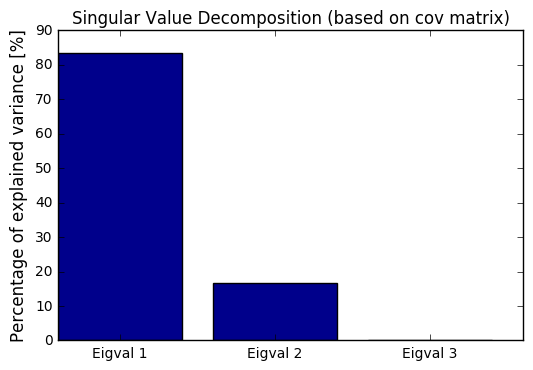

Number of critical principal components: 2


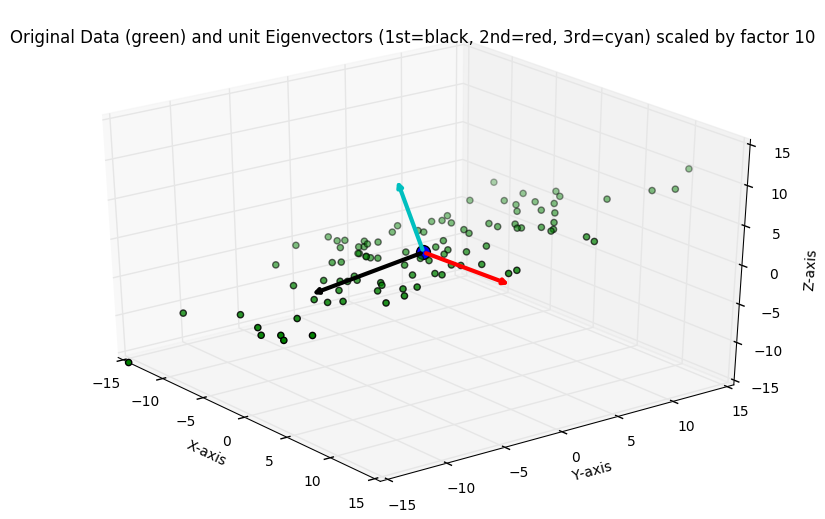

In [5]:
#### Let's plot everything - code for ALL graphs - Part A



# plot eigenvalues as bar graph
ind=np.arange(0,len(s))
plt.bar(ind,s/sum(s)*100, color='darkblue')
plt.ylabel('Percentage of explained variance [%]', fontsize=12)
plt.title('Singular Value Decomposition (based on cov matrix)', fontsize=12)
plt.xticks(ind + 0.4, ('Eigval 1','Eigval 2','Eigval 3'))
plt.show() 
print('Number of critical principal components: %.0f' %(ndim))


# plot data cloud in 3D with eigenvectors scaled by eigenvalues
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(X_demean[:,0], X_demean[:,1], X_demean[:,2], c='g', marker='o')
ax.scatter([0],[0],[0],s=100)
ax.set_title('Original Data (green) and unit Eigenvectors (1st=black, 2nd=red, 3rd=cyan) scaled by factor 10')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.view_init(elev=30, azim=-37.5)
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
ax.set_zlim(-15, 15)
 
scale=10
col_list=['k','r','c']
eigvec=U

i=0
for v in eigvec.T: # loop over eigenvectors
    a = Arrow3D([0, v[0]*scale], [0, v[1]*scale], 
                [0, v[2]*scale], mutation_scale=10, 
                lw=3, arrowstyle="-|>", color=col_list[i])
    i+=1
    ax.add_artist(a)
plt.show()



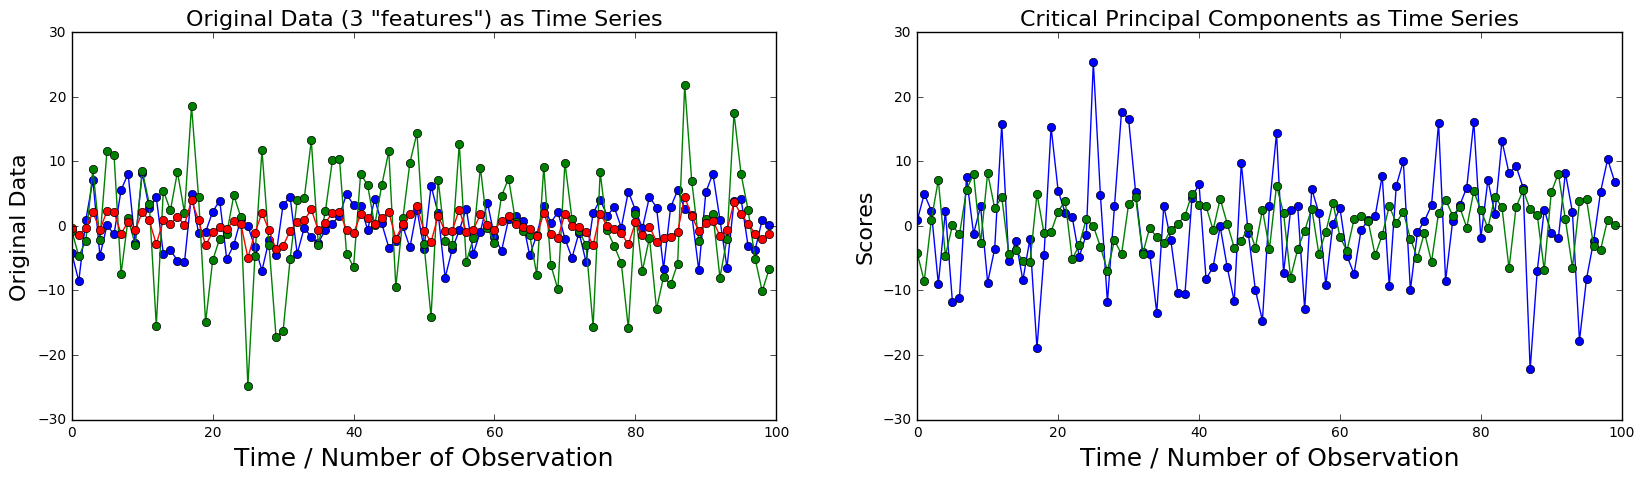

In [6]:
#### Let's plot everything - code for ALL graphs - Part B
%matplotlib inline
# 2D time series plots of original data and critical principal components
fig, axarr = plt.subplots(1,2, sharey=False, figsize=(20, 5), dpi=300, facecolor='w', edgecolor='k')
axarr[0].plot(X_demean,'-o')
axarr[0].set_title('Original Data (3 "features") as Time Series', fontsize=16)
axarr[0].set_ylabel('Original Data', fontsize=16)
axarr[0].set_xlabel('Time / Number of Observation', fontsize=18)
axarr[1].set_title('Critical Principal Components as Time Series',fontsize=16)
axarr[1].plot(scores[:,:ndim], '-o') # here critcal components are 2
axarr[1].set_ylabel('Scores', fontsize=16)
axarr[1].set_xlabel('Time / Number of Observation', fontsize=18)
plt.show()

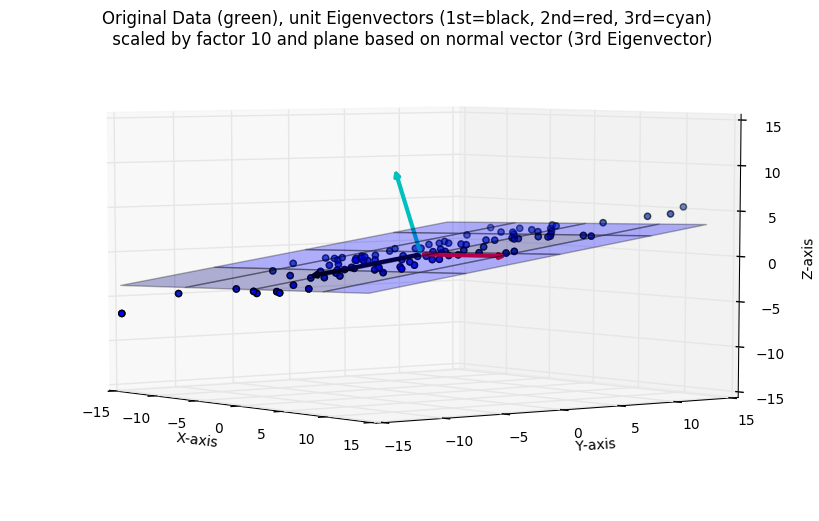

In [7]:
#%matplotlib notebook # Interactive plot - rotate view with mouse

# use normal vector/3rd eigenvector to fit a plane to the data cloud
normal=U[:,2]  # normal vector of the plane is the third eigenvector
Xgrid, Ygrid = np.meshgrid(np.arange(-15, 15, 1), np.arange(-15, 15, 1))
Zgrid = (1/normal[2]) * ( - (Xgrid*normal[0] + Ygrid*normal[1]))


fig = plt.figure(figsize=(8,5))
ax = Axes3D(fig)
ax.scatter(X_demean[:,0], X_demean[:,1], X_demean[:,2], c='g', marker='o')
ax.scatter(reconstruct[:,0], reconstruct[:,1], reconstruct[:,2], c='b', marker='o')
ax.plot_surface(Xgrid, Ygrid, Zgrid,rstride=8, cstride=8, alpha=0.3)
ax.set_title('Original Data (green), unit Eigenvectors (1st=black, 2nd=red, 3rd=cyan) \n scaled by factor 10 and plane based on normal vector (3rd Eigenvector)')
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.view_init(elev=5, azim=-37.5)
ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
ax.set_zlim(-15, 15)

scale=10
col_list=['k','r','c']
i=0

for v in eigvec.T: # loop over eigenvectors
  # mean/center is 0 here
    a = Arrow3D([0, 0 + v[0]*scale], [0, v[1]*scale], 
                [0, v[2]*scale], mutation_scale=10, 
                lw=3, arrowstyle="-|>", color=col_list[i])
    i+=1
    ax.add_artist(a)
plt.show()
